In [1]:
#---------------------------------------#
# author : https://github.com/vidit1999 #
#---------------------------------------#

In [2]:
# https://www.kaggle.com/deepcontractor/supreme-court-judgment-prediction

In [36]:
import re
import joblib
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import defaultdict
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords, names
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from IPython.core import pylabtools

from scipy.stats import hmean
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

sns.set_style('darkgrid')
pylabtools.figsize(10, 5)
warnings.filterwarnings("ignore")
tqdm.pandas()

In [9]:
random.seed(0)
np.random.seed(0)

In [10]:
# !7z l "../Data/supreme_court_judgement_prediction.zip"

In [11]:
# !7z x "../Data/supreme_court_judgement_prediction.zip" -o"../Data"

In [12]:
df = pd.read_csv("../Data/justice.csv", index_col=0)
df.head()

,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,70-18,1971,Jane Roe,Henry Wade,"<p>In 1970, Jane Roe (a fictional name used in...",501,7,2,True,majority opinion,reversed,NaN
1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3303 entries, 0 to 3302
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  3303 non-null   int64 
 1   name                3303 non-null   object
 2   href                3303 non-null   object
 3   docket              3303 non-null   object
 4   term                3303 non-null   object
 5   first_party         3302 non-null   object
 6   second_party        3302 non-null   object
 7   facts               3303 non-null   object
 8   facts_len           3303 non-null   int64 
 9   majority_vote       3303 non-null   int64 
 10  minority_vote       3303 non-null   int64 
 11  first_party_winner  3288 non-null   object
 12  decision_type       3296 non-null   object
 13  disposition         3231 non-null   object
 14  issue_area          3161 non-null   object
dtypes: int64(4), object(11)
memory usage: 412.9+ KB


In [14]:
df.columns

Index(['ID', 'name', 'href', 'docket', 'term', 'first_party', 'second_party',
       'facts', 'facts_len', 'majority_vote', 'minority_vote',
       'first_party_winner', 'decision_type', 'disposition', 'issue_area'],
      dtype='object')

In [15]:
df['first_party_winner'].value_counts(dropna=False)

True     2140
False    1148
NaN        15
Name: first_party_winner, dtype: int64

In [16]:
df['decision_type'].value_counts(dropna=False)

majority opinion                     2829
per curiam                            267
plurality opinion                     153
equally divided                        17
dismissal - rule 46                     9
dismissal - other                       8
NaN                                     7
dismissal - improvidently granted       6
dismissal - moot                        5
memorandum                              1
opinion of the court                    1
Name: decision_type, dtype: int64

In [17]:
df['first_party'].value_counts()

United States                          201
Florida                                 12
Maryland                                11
Arizona                                 10
California                               9
                                      ... 
Rice                                     1
Hill                                     1
Vermont Agency of Natural Resources      1
Garner                                   1
PennEast Pipeline Co. LLC                1
Name: first_party, Length: 2764, dtype: int64

In [18]:
df['issue_area'].value_counts()

Criminal Procedure      859
Civil Rights            568
Economic Activity       542
First Amendment         353
Judicial Power          342
Due Process             128
Federalism              125
Privacy                  70
Unions                   60
Federal Taxation         51
Attorneys                37
Miscellaneous            20
Private Action            4
Interstate Relations      2
Name: issue_area, dtype: int64

In [19]:
df['disposition'].value_counts()

reversed/remanded            1073
affirmed                     1007
reversed                      585
vacated/remanded              430
reversed in-part/remanded      61
none                           41
reversed in-part               22
vacated                         7
vacated in-part/remanded        5
Name: disposition, dtype: int64

In [20]:
df_n = df[['facts', 'facts_len','issue_area', 'first_party_winner']]

In [21]:
df_n

,facts,facts_len,issue_area,first_party_winner
0,"<p>In 1970, Jane Roe (a fictional name used in...",501,NaN,True
1,<p>Joan Stanley had three children with Peter ...,757,Civil Rights,True
2,<p>John Giglio was convicted of passing forged...,495,Due Process,True
3,"<p>The Idaho Probate Code specified that ""male...",378,Civil Rights,True
4,"<p>Miller, after conducting a mass mailing cam...",305,First Amendment,True
...,...,...,...,...
3298,"<p>Refugio Palomar-Santiago, a Mexican nationa...",2054,Criminal Procedure,True
3299,<p>Tarahrick Terry pleaded guilty to one count...,1027,Criminal Procedure,False
3300,<p>Joshua James Cooley was parked in his picku...,1309,Civil Rights,True
3301,<p>This is an ongoing case of original jurisdi...,297,NaN,False


In [22]:
df_n.dropna(subset=['facts', 'facts_len','first_party_winner'], inplace=True)

In [23]:
df_n['issue_area'].fillna('Miscellaneous', inplace=True)

In [24]:
df_n.reset_index(drop=True, inplace=True)

In [25]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   facts               3288 non-null   object
 1   facts_len           3288 non-null   int64 
 2   issue_area          3288 non-null   object
 3   first_party_winner  3288 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.9+ KB


<AxesSubplot:xlabel='first_party_winner', ylabel='count'>

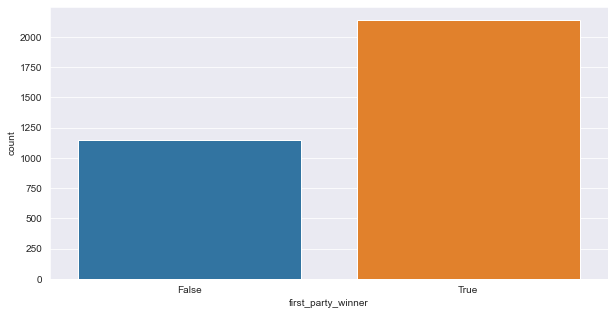

In [26]:
sns.countplot(x='first_party_winner', data=df_n)

In [27]:
tag_map = defaultdict(
    lambda : "n",
    {
        'J' : "a",
        'V' : "v",
        'R' : "r",
    }
)
eng_stopwords = set(stopwords.words('english'))
all_names = set(map(str.lower, names.words('male.txt') + names.words('female.txt')))
lemma = WordNetLemmatizer()

In [28]:
def clean_sent(data):
    data = BeautifulSoup(data).get_text()
    data = data.lower() # lowering
    data = data.encode("ascii", "ignore").decode() # non ascii chars
    data = re.sub(r'\n',' ', data) # remove new-line characters
    data = re.sub(r'\W', ' ', data) # special chars
    data = re.sub(r'\s+[a-zA-Z]\s+', ' ', data) # single characters
    data = re.sub(r'\^[a-zA-Z]\s+', ' ', data) # single char at first
    data = re.sub(r'[0-9]', ' ', data) # digits
    data = re.sub(r'\s+', ' ', data, flags=re.I) # multiple spaces
    return ' '.join([
        lemma.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(word_tokenize(data))
        if token not in eng_stopwords and token not in all_names
    ])

In [29]:
df_n['facts'] = df_n['facts'].progress_apply(clean_sent)

  0%|          | 0/3288 [00:00<?, ?it/s]

In [30]:
df_n

,facts,facts_len,issue_area,first_party_winner
0,roe fictional name use court document protect ...,501,Miscellaneous,True
1,three child stanley never marry live together ...,757,Civil Rights,True
2,giglio convict pass forged money order appeal ...,495,Due Process,True
3,idaho probate code specify male must prefer fe...,378,Civil Rights,True
4,miller conduct mass mail campaign advertise sa...,305,First Amendment,True
...,...,...,...,...
3283,refugio palomar santiago mexican national gran...,2054,Criminal Procedure,True
3284,tarahrick plead guilty one count possession in...,1027,Criminal Procedure,False
3285,cooley park pickup truck side road within crow...,1309,Civil Rights,True
3286,ongoing original jurisdiction fact explain sum...,297,Miscellaneous,False


<AxesSubplot:>

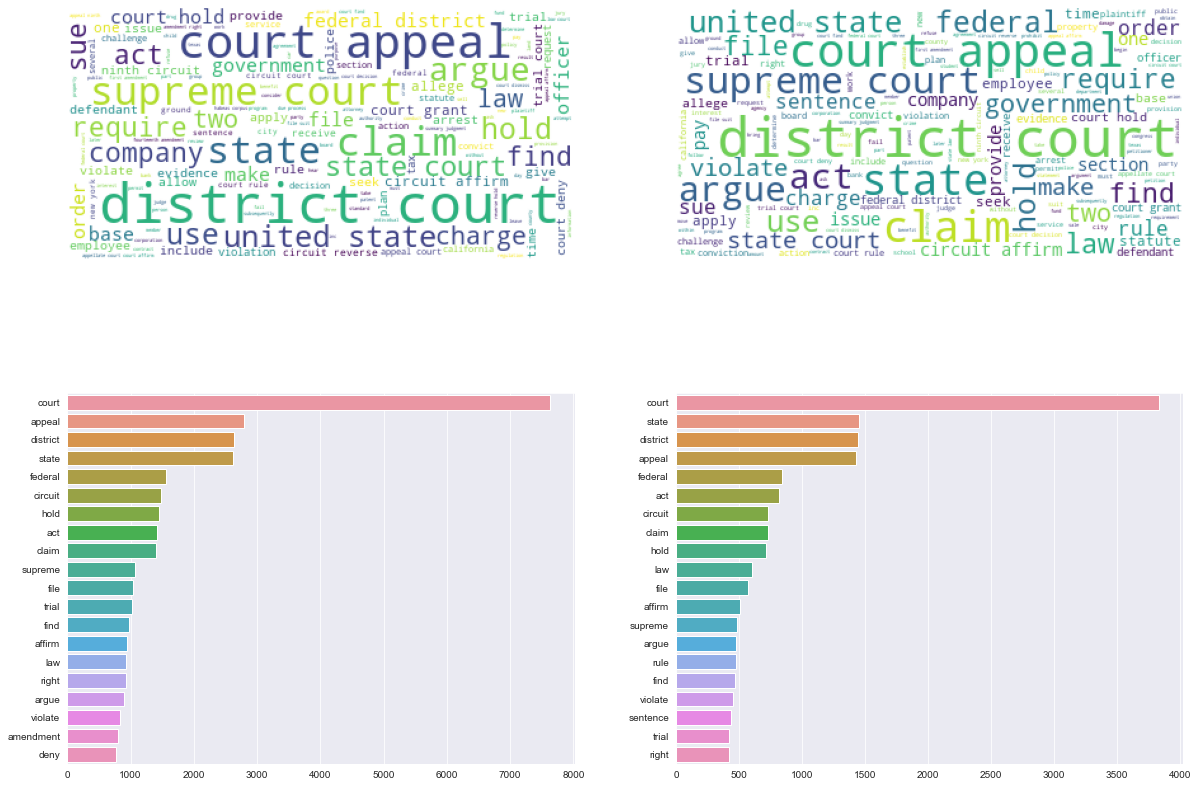

In [59]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

# word clouds
wc_fp_winner = WordCloud(background_color='white').generate(' '.join(df_n[df_n['first_party_winner'] == True]['facts']))
wc_not_fp_winner = WordCloud(background_color='white').generate(' '.join(df_n[df_n['first_party_winner'] == False]['facts']))

# most frequent 20 words
fq_fp_winner_20 = dict(FreqDist(word_tokenize(' '.join(df_n[df_n['first_party_winner'] == True]['facts']))).most_common(20))
fq_not_fp_winner_20 = dict(FreqDist(word_tokenize(' '.join(df_n[df_n['first_party_winner'] == False]['facts']))).most_common(20))

axs[0][0].imshow(wc_fp_winner)
axs[0][1].imshow(wc_not_fp_winner)

axs[0][0].axis('off')
axs[0][1].axis("off")

sns.barplot(y=list(fq_fp_winner_20.keys()), x=list(fq_fp_winner_20.values()), ax=axs[1][0])
sns.barplot(y=list(fq_not_fp_winner_20.keys()), x=list(fq_not_fp_winner_20.values()), ax=axs[1][1])

In [60]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_df=0.99, min_df=0.01)
tfidf_X = tfidf.fit_transform(df_n['facts'])
tfidf_df = pd.DataFrame(tfidf_X.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df

,ability,able,abortion,abuse,accept,access,accident,accord,accordance,account,...,writ habeas,write,year,year later,year old,year prison,year statute,yet,york,young
0,0.0,0.0,0.200736,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.066755,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.171401,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.041865,0.075648,0.0,0.0,0.0,0.0,0.0,0.0
3284,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.128566,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3285,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3286,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
ohe = OneHotEncoder(sparse=False)
ohe_df = pd.DataFrame(ohe.fit_transform(df_n['issue_area'].to_numpy().reshape(-1, 1)), columns=ohe.get_feature_names_out())
ohe_df

,x0_Attorneys,x0_Civil Rights,x0_Criminal Procedure,x0_Due Process,x0_Economic Activity,x0_Federal Taxation,x0_Federalism,x0_First Amendment,x0_Interstate Relations,x0_Judicial Power,x0_Miscellaneous,x0_Privacy,x0_Private Action,x0_Unions
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3284,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3285,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [62]:
le = LabelEncoder()

df_n['first_party_winner'] = le.fit_transform(df_n['first_party_winner'])

In [63]:
mms = MinMaxScaler()

df_n['facts_len_scaled'] = mms.fit_transform(df_n['facts_len'].to_numpy().reshape(-1, 1)).flatten()

In [64]:
df_n = pd.concat([df_n, tfidf_df, ohe_df], axis=1)

In [65]:
df_n

,facts,facts_len,issue_area,first_party_winner,facts_len_scaled,ability,able,abortion,abuse,accept,...,x0_Economic Activity,x0_Federal Taxation,x0_Federalism,x0_First Amendment,x0_Interstate Relations,x0_Judicial Power,x0_Miscellaneous,x0_Privacy,x0_Private Action,x0_Unions
0,roe fictional name use court document protect ...,501,Miscellaneous,1,0.076923,0.0,0.0,0.200736,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,three child stanley never marry live together ...,757,Civil Rights,1,0.118381,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,giglio convict pass forged money order appeal ...,495,Due Process,1,0.075951,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,idaho probate code specify male must prefer fe...,378,Civil Rights,1,0.057004,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,miller conduct mass mail campaign advertise sa...,305,First Amendment,1,0.045182,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,refugio palomar santiago mexican national gran...,2054,Criminal Procedure,1,0.328421,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3284,tarahrick plead guilty one count possession in...,1027,Criminal Procedure,0,0.162105,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3285,cooley park pickup truck side road within crow...,1309,Civil Rights,1,0.207773,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3286,ongoing original jurisdiction fact explain sum...,297,Miscellaneous,0,0.043887,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [66]:
X = df_n.iloc[:,4:]
y = df_n.iloc[:,3]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [68]:
X_train.shape, X_test.shape

((2466, 1588), (822, 1588))

In [69]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [70]:
X_resampled.shape

(3220, 1588)

In [74]:
classifiers = {
    "logistic": LogisticRegression(),
    "random_forest": RandomForestClassifier(),
    "decision_tree": DecisionTreeClassifier(),
    "k_neighbour": KNeighborsClassifier(),
    "sgd": SGDClassifier(),
    "xg_boost": XGBClassifier(eval_metric='logloss'),
    "light_gbm": LGBMClassifier(),
    "gaussian_nb": GaussianNB(),
    "bernouli_nb": BernoulliNB(),
}

In [75]:
def accuracy_f1_comboned(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return hmean([acc, f1])

  0%|          | 0/9 [00:00<?, ?it/s]

Classifier: LOGISTIC            Finished
Classifier: RANDOM_FOREST       Finished
Classifier: DECISION_TREE       Finished
Classifier: K_NEIGHBOUR         Finished
Classifier: SGD                 Finished
Classifier: XG_BOOST            Finished
Classifier: LIGHT_GBM           Finished
Classifier: GAUSSIAN_NB         Finished
Classifier: BERNOULI_NB         Finished


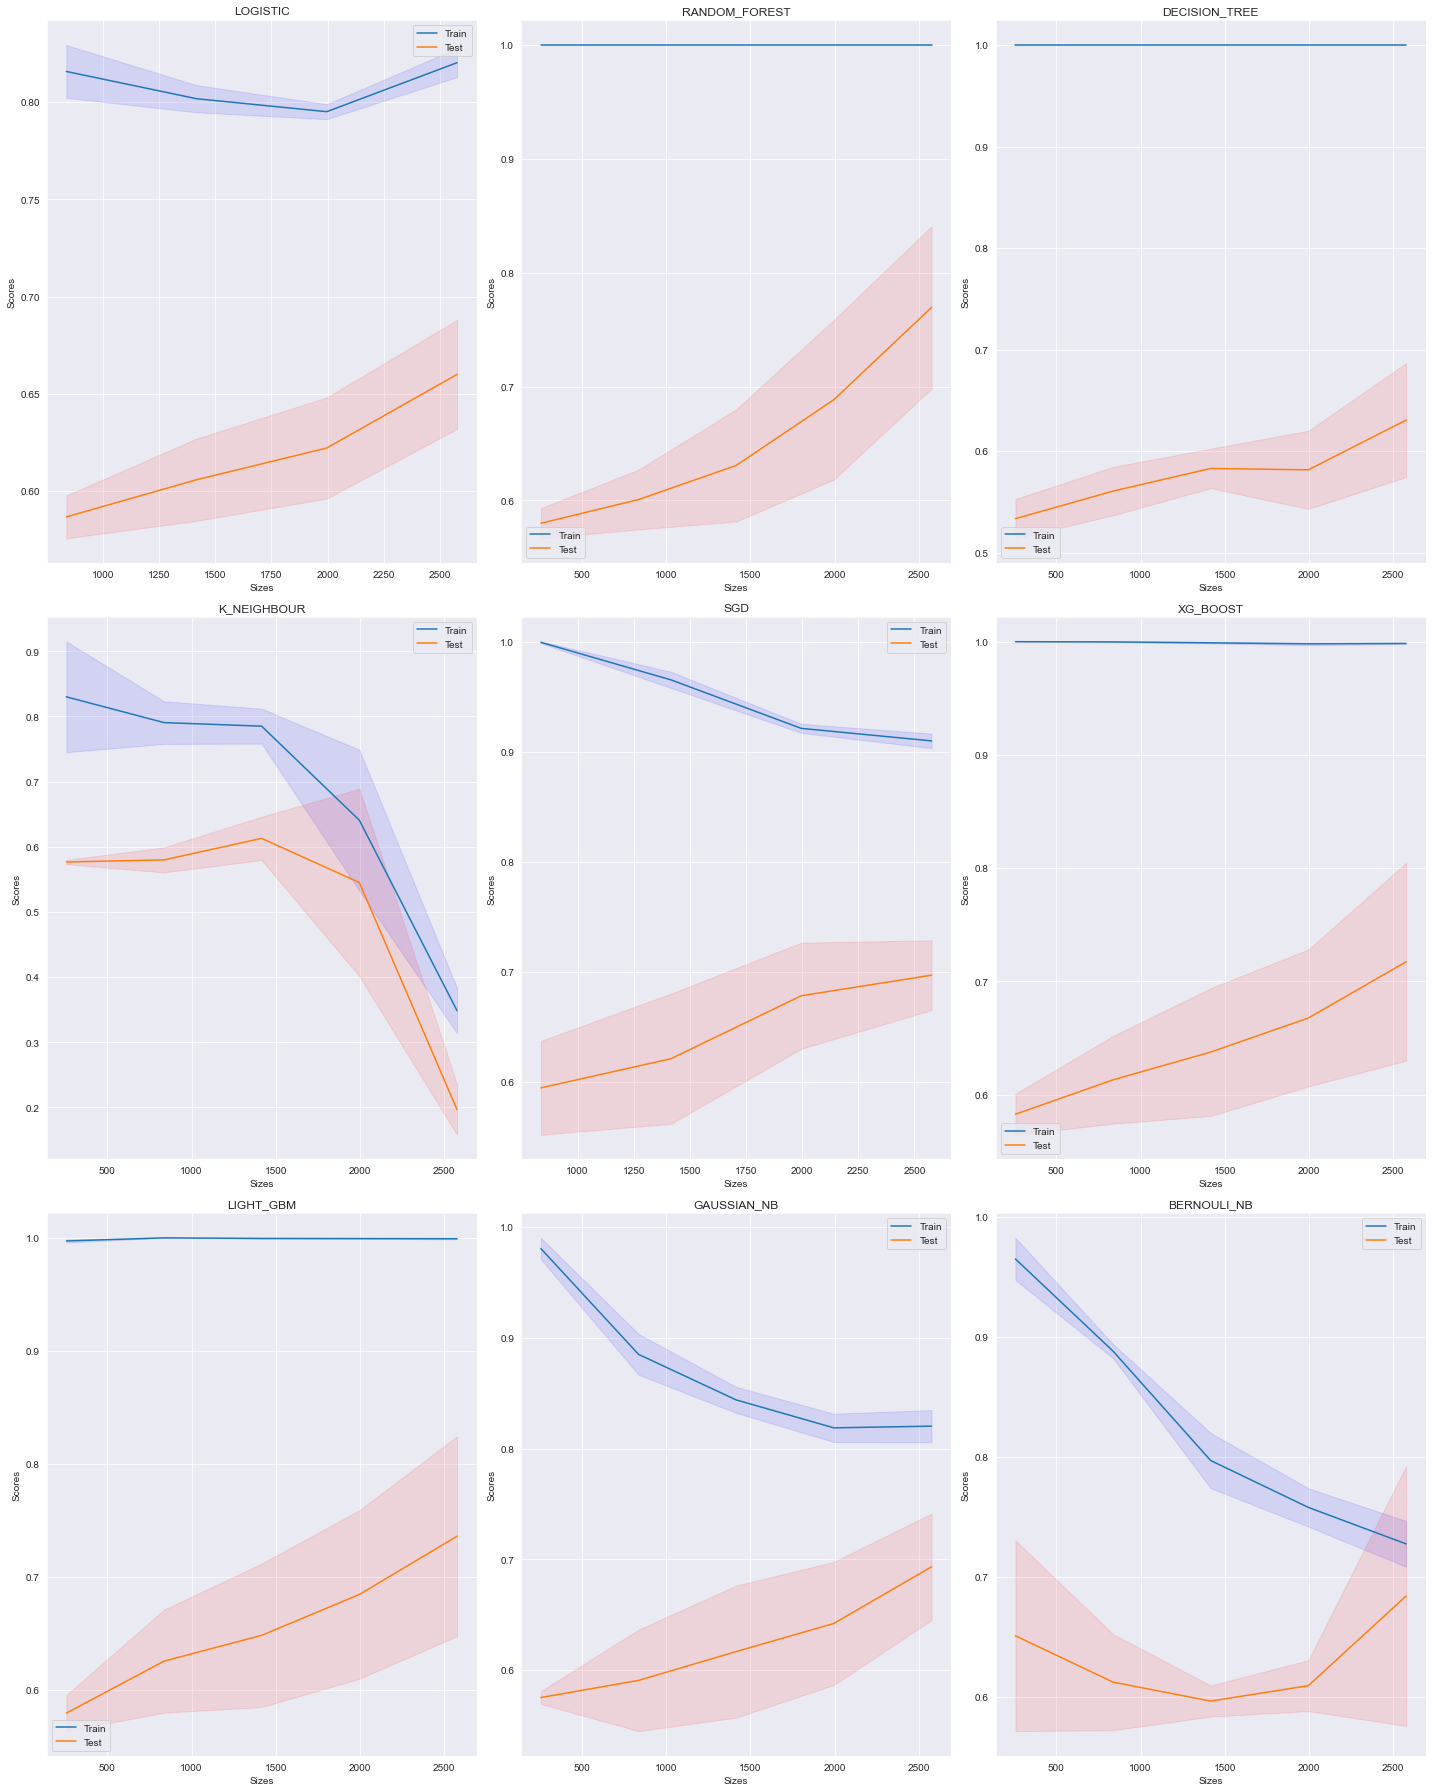

In [76]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))
train_size_spaces = np.linspace(0.1, 1.0, 5)

for i, (name, clf) in enumerate(tqdm(classifiers.items())):
    print(f"Classifier: {name.upper():20}", end='')
    train_sizes, train_scores, test_scores = learning_curve(
        clf, X_resampled, y_resampled,
        train_sizes=train_size_spaces,
        scoring=make_scorer(accuracy_f1_comboned),
        n_jobs=-1
    )
    print("Finished")
    
    train_score_mean = np.mean(train_scores, axis=1)
    test_score_mean = np.mean(test_scores, axis=1)
    train_score_std = np.std(train_scores, axis=1)
    test_score_std = np.std(test_scores, axis=1)
    
    ax = axs[i//3][i%3]
    
    sns.lineplot(x=train_sizes, y=train_score_mean, label='Train', ax=ax)
    sns.lineplot(x=train_sizes, y=test_score_mean, label='Test', ax=ax)
    ax.fill_between(
        train_sizes,
        train_score_mean - train_score_std,
        train_score_mean + train_score_std,
        alpha=0.1,
        color="b",
    )
    ax.fill_between(
        train_sizes,
        test_score_mean - test_score_std,
        test_score_mean + test_score_std,
        alpha=0.1,
        color="r",
    )
    
    ax.set_xlabel("Sizes")
    ax.set_ylabel("Scores")
    ax.set_title(f"{name.upper()}")
    
fig.tight_layout()

In [88]:
param_grid = {
    'class_weight': [None, "balanced"],
    'criterion': ["gini", "entropy"],
    'max_features': ["sqrt", "log2"],
    'n_estimators': np.arange(0, 500, 100)+100
}

In [89]:
gscv = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    scoring=make_scorer(accuracy_f1_comboned),
    cv=4,
    n_jobs=-1,
    verbose=2
).fit(X_resampled, y_resampled)

Fitting 4 folds for each of 40 candidates, totalling 160 fits


In [90]:
gscv.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_features': 'log2',
 'n_estimators': 500}

In [91]:
cv_results = pd.DataFrame(gscv.cv_results_).sort_values('rank_test_score', ascending=True)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
9,8.060231,0.476735,0.387622,0.079036,None,gini,log2,500,"{'class_weight': None, 'criterion': 'gini', 'm...",0.709378,0.722979,0.855939,0.875537,0.790958,0.075254,1
39,13.860063,0.589848,0.471503,0.040272,balanced,entropy,log2,500,"{'class_weight': 'balanced', 'criterion': 'ent...",0.713128,0.720148,0.856534,0.862668,0.788120,0.071557,2
27,5.205715,0.307364,0.233892,0.011128,balanced,gini,log2,300,"{'class_weight': 'balanced', 'criterion': 'gin...",0.710460,0.728882,0.851769,0.858334,0.787361,0.068042,3
18,7.549522,0.624461,0.323177,0.068186,None,entropy,log2,400,"{'class_weight': None, 'criterion': 'entropy',...",0.712662,0.718787,0.861085,0.855432,0.786991,0.071328,4
29,8.105273,0.418940,0.393643,0.073737,balanced,gini,log2,500,"{'class_weight': 'balanced', 'criterion': 'gin...",0.698558,0.722185,0.863034,0.856884,0.785165,0.075290,5
8,6.743335,0.344901,0.297032,0.009624,None,gini,log2,400,"{'class_weight': None, 'criterion': 'gini', 'm...",0.703876,0.720485,0.850792,0.859781,0.783733,0.071864,6
28,6.708435,0.339949,0.294709,0.005055,balanced,gini,log2,400,"{'class_weight': 'balanced', 'criterion': 'gin...",0.698034,0.710394,0.858903,0.864107,0.782860,0.078788,7
19,9.504316,0.965245,0.436474,0.088971,None,entropy,log2,500,"{'class_weight': None, 'criterion': 'entropy',...",0.702983,0.712343,0.858903,0.856884,0.782778,0.075191,8
7,5.112998,0.261841,0.231908,0.008379,None,gini,log2,300,"{'class_weight': None, 'criterion': 'gini', 'm...",0.702089,0.712112,0.850375,0.865544,0.782530,0.075703,9
16,3.809037,0.285154,0.149156,0.004955,None,entropy,log2,200,"{'class_weight': None, 'criterion': 'entropy',...",0.706437,0.702331,0.858708,0.861225,0.782175,0.077810,10


In [92]:
rfc = RandomForestClassifier(**gscv.best_params_).fit(X_resampled, y_resampled)
rfc

RandomForestClassifier(max_features='log2', n_estimators=500)

Confusion Matrix
              precision    recall  f1-score   support

           0     0.3923    0.1747    0.2417       292
           1     0.6517    0.8509    0.7381       530

    accuracy                         0.6107       822
   macro avg     0.5220    0.5128    0.4899       822
weighted avg     0.5596    0.6107    0.5618       822

Accuracy score : 0.610705596107056
F1 score : 0.7381342062193126
Accuracy F1 combined : 0.6684006353292671


Text(0.5, 25.0, 'Predicted Label')

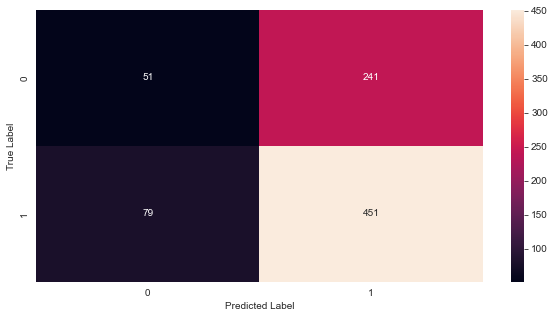

In [96]:
pred = rfc.predict(X_test)

print("Confusion Matrix")
print(classification_report(y_test, pred, digits=4))

print(f"Accuracy score : {accuracy_score(y_test, pred)}")
print(f"F1 score : {f1_score(y_test, pred)}")
print(f"Accuracy F1 combined : {accuracy_f1_comboned(y_test, pred)}")

ax = sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d')
ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label")

In [97]:
joblib.dump([
    tfidf, ohe, le, smote, mms, rfc
], "../Data/supreme_court_judgement_pred.pkl")

['../Data/supreme_court_judgement_pred.pkl']